# DNN POUR ENVIRONNEMENT STATIONNAIRE

Ce tutoriel crée un Deep Neural Network qui prédit l'outcome d'une action. La prédiction est correcte si une meme action produit toujours un même outcome.

# On crée le modèle

Exemple: une couche de 10 neurones et une couche de 5 :

In [76]:
hidden_size = [10, 5]

ou autre exemple avec une couche de 3 neurones qui est siffisant pour l'environnement 1 :

In [117]:
hidden_size = [3]

In [118]:
# Importe le modèle préparé par PE
from model.DeepNN import DeepNetwork

# Entrée: 1 action 
# Sortie: 2 probabilités (une pour chaque outcome)
model_ML = DeepNetwork(hidden_size=hidden_size, input_size=1, output_size=2)
model_ML.to("cpu")

liste hidden init [3]


DeepNetwork(
  (fc1): Linear(in_features=1, out_features=3, bias=True)
  (hidden_layers): ModuleList()
  (fc4): Linear(in_features=3, out_features=2, bias=True)
)

# On tokenize le vocabulaire

In [119]:
# Import le tokenizer préparé par PE
from model.Tokenizer import SimpleTokenizerV1
from outil import create_dico_numerate_word

# Notre vocabulaire:
all_word = create_dico_numerate_word(['x', 'y', 'a', 'b'])
# Voici all_word : {'x': 0, 'y': 1, 'a': 2, 'b': 3}
print("Vocabulaire:", all_word)
# Nous n'avons pas besoin d'un tokenzier complexe, 
# il va avoir le même rôle qu'un dictionnaire
tokenizer = SimpleTokenizerV1(all_word)
# Maintenant pour encoder une action ou un outcome nous pouvons faire :
print('Test encode a:', tokenizer.encode('a'))
# et pour decoder :
print('Test decode 1:', tokenizer.decode(1))

Vocabulaire: {'x': 0, 'y': 1, 'a': 2, 'b': 3}
Test encode a: 2
Test decode 1: y


# On définit les paramètres du modèle

Le `lr` et le `weight_decay` sont des paramètres très importants qui vont permettre de corriger plus ou moins vite le modèle. Une correction rapide est moins précise.


In [120]:
lr = 1e-1
weight_decay = 1e-2

In [121]:
# On importe les outils fournis par torch
import torch
import torch.nn as nn

# Le modèle a besoin d'un optimizer pour corriger les poids.
optimizer = torch.optim.Adam(model_ML.parameters(), lr=lr, weight_decay=weight_decay)

# Nous avons aussi besoin d'une fonction de loss, par exemple la CrossEntropy
# Au vue de la simplicité de prédiction le type de loss importe peu
loss_func = nn.CrossEntropyLoss()

# On crée un dataset d'évaluation

l'action `a` renvoie l'outcome `x`. L'action `b` renvoie l'outcome `y`.

In [122]:
tokenized_actions = [[tokenizer.encode('a')], [tokenizer.encode('b')]]
tokenized_outomes = [tokenizer.encode('x'), tokenizer.encode('y')]

# Convertit en tensors pour torch
x = torch.tensor(tokenized_actions, dtype=torch.float).to("cpu")
y = torch.tensor(tokenized_outomes, dtype=torch.long).to("cpu")

# Notre dataset de test :
print("x (tokenized actions):\n", x)
print("y (tokenized outcomes):\n", y)

x (tokenized actions):
 tensor([[2.],
        [3.]])
y (tokenized outcomes):
 tensor([0, 1])


On crée un loader pour charger le dataset d'évaluation

In [123]:
# Nous utilisons un dataLoader de pytorch
# Le batch_size n'a pas d'importance de même que le shuffle
validate_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x, y),
    batch_size=32, shuffle=False
)

# La fonction fit()

In [124]:
# Importe la fonction train préparée par PE
from model.DeepNN import train

def fit(action, outcome):
    action = tokenizer.encode(action)
    action = torch.tensor([action], dtype=torch.float).to("cpu")
    outcome = tokenizer.encode(outcome)
    outcome = torch.tensor(outcome, dtype=torch.long).to("cpu")
    outcome = torch.nn.functional.one_hot(outcome, num_classes=2).to(torch.float)
    # On passe le modèle en mode train
    model_ML.train()
    # On appelle la fonction d'entrainement 
    train(model=model_ML, 
          train_data=[(action, outcome)],
          optimizer=optimizer,
          loss_func=loss_func,
          nb_epochs=1,
          validate_loader=None, # validate_loader,
          print_=True)

On entraine le modèle dans en environnement ou action `a` produit outcome `x` et action `b` produit outcome `y`.

Utiliser `Ctrl` + `Enter` pour l'exécuter plusieurs fois et voir la loss diminuer à chaque appel.

In [169]:
fit('a', 'x')
fit('b', 'y')

Epoch 1/1,, Loss: 0.5703
Epoch 1/1,, Loss: 0.4169


Visualisons les prédictions du modèle :

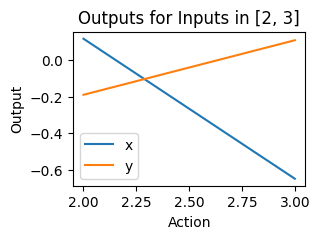

In [170]:
import matplotlib.pyplot as plt

# Generate inputs in the range [2, 3]
inputs = torch.linspace(2, 3, steps=100).unsqueeze(1)  # Shape (100,1)

# Pass inputs through the model
outputs = model_ML(inputs)

# Extract the first output value for each input
output_x = outputs[:, 0].detach().numpy()  # Detach and convert to NumPy
output_y = outputs[:, 1].detach().numpy()  # Detach and convert to NumPy

# Plot results
plt.figure(figsize=(3, 2))  # Reduce figure size by half
plt.plot(inputs.numpy(), output_x, label="x")
plt.plot(inputs.numpy(), output_y, label="y")
plt.xlabel("Action")
plt.ylabel("Output")
plt.title("Outputs for Inputs in [2, 3]")
plt.legend()
plt.show()

Il faut entrainer le modèle jusqu'a ce que `x` soit au dessus de `y` pour action 2 et en dessous pour action 3.

# La fonction predict()

In [65]:
def predict(action):
    action = tokenizer.encode(action)
    action = torch.tensor([action], dtype=torch.float).to("cpu")
    model_ML.eval() # On peut le passer en mode evaluation
    prediction_tensor = model_ML(action)
    print(prediction_tensor)
    predicted_outcome_token = torch.argmax(prediction_tensor, dim=0).item()
    return tokenizer.decode(predicted_outcome_token)

In [66]:
predicted_outcome = predict('a')
print("Prediction pour a:", predicted_outcome)
predicted_outcome = predict('b')
print("Prediction pour b:", predicted_outcome)

tensor([ 0.8929, -0.7409], grad_fn=<ViewBackward0>)
Prediction pour a: x
tensor([-0.9703,  0.9918], grad_fn=<ViewBackward0>)
Prediction pour b: y


Si le modèle a été suffisement entrainé, il prédit correctement que action `a` produit outcome `x` et `b` produit `y`.